<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Data" data-toc-modified-id="The-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Data</a></span></li><li><span><a href="#Digital-Referral-Numbers" data-toc-modified-id="Digital-Referral-Numbers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Digital Referral Numbers</a></span><ul class="toc-item"><li><span><a href="#Reasons-for-Referrals" data-toc-modified-id="Reasons-for-Referrals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reasons for Referrals</a></span><ul class="toc-item"><li><span><a href="#Approach:" data-toc-modified-id="Approach:-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Approach:</a></span></li><li><span><a href="#Findings:" data-toc-modified-id="Findings:-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Findings:</a></span></li></ul></li><li><span><a href="#Referral-Numbers" data-toc-modified-id="Referral-Numbers-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Referral Numbers</a></span></li><li><span><a href="#Timing-of-Referrals" data-toc-modified-id="Timing-of-Referrals-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Timing of Referrals</a></span></li><li><span><a href="#Word-Clouds---Exploring-the-Text" data-toc-modified-id="Word-Clouds---Exploring-the-Text-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Word Clouds - Exploring the Text</a></span></li><li><span><a href="#HIVST" data-toc-modified-id="HIVST-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>HIVST</a></span></li></ul></li></ul></div>

In [1]:
%run "../../xUtilz/utilz_only_loader.ipynb"

In [2]:
db = pd.read_csv( "../../datasets/LG/IN/181112_Referral_Reasons.csv" )
#db.head(5)
#db.dtypes

In [3]:
## anonymize
#db["CHV Name"] = db["CHV Name"].apply( lambda x: hash( x.strip() ) )
#db["Patient Name"] = db["Patient Name"].apply( lambda x: hash( x.strip() ) )
#db["CHV Phone"] = db["CHV Phone"].apply( lambda x: hash( str(x).strip() ) )
#db.drop( "CHV Phone" )

db["CHV Name"] = "CHV " +  pd.Series( pd.factorize( db["CHV Name"])[0] + 1).astype( str)
db["Patient Name"] = "Patient " +  pd.Series( pd.factorize( db["Patient Name"])[0] + 1).astype( str)
db.drop( "CHV Phone", axis=1, inplace=True)

In [4]:
## Add Category column for Referral Reasons
reasons_groupz = { 
    "Neonates" : [ "months", "umbilical", "umbllical"], 
    "Pregnancy" : ["delivery"], 
    "U5 Danger Signs" : [ "Danger", "Diarrhoea", "Diarrhea", "Dairrhea", "Coughing", "Cough", "Fever","Pneumonia", "Pnuemonia",
                        "Pheumonia", ],
    "HIVST" : ["reactive", "partner", "intimate"], 
    "Unsupported Cases" : []
}

db["Reason for Referral"] = db["Referral Reason"].apply( lambda x: searchString(x, reasons_groupz) ) 

var_Unsupported = "Unsupported Cases"
var_HIVST = "HIVST"
var_Display_Colz = ["Date of referral", "CHV Name", "Patient Name" ,"Referral Reason", "Reason for Referral"]

In [5]:
# 1. set Date of referral to a datetime type 
db["Date of referral"] = pd.to_datetime( db["Date of referral"], format="%d-%b-%y") # inplace=True)

# 2. Extract Month and year categories 
#db["Month_Number"] = db["Date of referral"].dt.month
#db["Month_Name"] = db["Date of referral"].dt.strftime('%b')
db["Year"] = db["Date of referral"].dt.year 
#db["Month_Period"] = db["Date of referral"].dt.to_period('M') # M - month period in #  pd.to_datetime( 
db["Month"] = db["Date of referral"].dt.strftime('%b-%y') 
db["Day_of_Week"] = db["Date of referral"].dt.weekday_name.str[:3] 

db.sort_values( by='Date of referral', inplace=True)

LAST_UPDATED = db["Date of referral"].max().strftime( '%d-%b-%Y')

# The Data

Here's a glimpse at the data being analyzed
- Grouping by CU  and some CHV trait is not possible yet b/c there are no mappings for that yet. 
- Referral reason and Timing of the referral are the main perspectives 

Updates
- The dataset will get updated weekly. 
- This data covers the period 22-Aug-2018 to 9-Nov {{LAST_UPDATED}} 

In [6]:
print("A glimpse at a sample of the data")
db.sample(5)

A glimpse at a sample of the data


,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral,Year,Month,Day_of_Week
36,2018-08-28,CHV 5,Patient 36,NaN,No Response,2018,Aug-18,Tue
4,2018-10-12,CHV 5,Patient 5,Backache,Unsupported Cases,2018,Oct-18,Fri
26,2018-10-22,CHV 2,Patient 26,Noise has a problem .,Unsupported Cases,2018,Oct-18,Mon
19,2018-10-28,CHV 13,Patient 19,CHV referral: reactive or non-disclose,HIVST,2018,Oct-18,Sun
54,2018-09-26,CHV 4,Patient 53,Ameumia mgongo,Unsupported Cases,2018,Sep-18,Wed


# Digital Referral Numbers 

## Reasons for Referrals

n = 129 referrals {{len(db)}}


### Approach: 
A quick categorization of the open-ended reason for referral field. Categories are based on 
- Danger Signs: ICCM cases get a referral if there's a danger sign 
- Neonates: All kids under 2 months get a referral after a '+ve' assessment 
- Pregnancy: Pregnancy related cases during ANC/PNC follow ups 
- HIVST: Referrals specific to HIVST linkage 
- Unsupported: Non-LG supported cases. Primarily generated by the 'free-form' digital referral form, which is a catch-all 


### Findings:

Note: Small sample size for sub-groups

**Potentially Increasing Uptake:** Number of referrals have an increasing pattern over the three months. For instance, the proportion of referrals increase from 35% to 47% from September to October.
- **Questions:**
    - We'll keep watch on if this continues to grow.
    - Need to add data on the average referrals per CHV per month and the % of CHVs with referral activities for more perspective. 


**High # Unsupported Case:** Unsupported cases make up 40% of the referrals. They top the reason for referral. 
- ICCM danger signs come second with 38% of the referrals. 
- When we started in August, ICCM cases were the most. However, August activity was for 2 weeks or less. 
- Cannibalization: The average number of referrals per CHV per month is about 2, which is inline with the main program expectations. So if there are high unsupported cases without an increase in the average number of referrals per CHV per month, then CHVs are likely swapping referral activity at the expense of the MNCH focus areas. 
- Note though, this is based on a loose view of the open-ended text input for this variable with a quick scan for sensibility. 

- **Questions:** Follow up questions are  
    - Is there main program data for unsupported cases? So far, this is a no - main program 2 - 3 referral targets are for MNCH focus areas. 
    - Qualitative follow up on why.


**Monday and Thursdays are most active:** Most of the referrals are generated on a Monday or Thursday. 
- There seems to be two moments of activition, Monday and Thursday, and with a declining trend for each 
- ICCM referral activity is most on Mondays and Fridays. 
- Neonate activity is most on Mondays and all 6 cases happen in the first moment.

- **Questions:**
    - Relate to the high number of unsupported cases. 
    - Relate to ICCM, Neonate and Pregnancy targets per CHV per month for cannibalization particularly 
    
    

**HIVST Cases**
- 18% of HIVST referrals are because of IPV concerns 



## Referral Numbers

1. Unsupported cases are the main reason for referral 
    - This is as per a general categorization
    - See the word clouds for word specific frequencies 

3. Potential cannibalization of MNCH referral activity by general referral 
    - Digital referral has a workflow for general cases
    - The average number of referrals per CHV per month doesn't seem to have changed with digital referral; we're at 2 referrals per CHV per month, which is similar to baseline. 
    - So, if the main program doesn't record general referral cases, then we're potentially seeing some cannibalizatin of MNCH activity. However, this doesn't take into account the following, which ought to be investigated.  
        - Number of assessments made by trial group compared to baseline and control. Baseline proportions were that about 16% of assessments resulted in a referral. The targets have been 16 assessments per CHV per month. 
        - Interaction of incentives. What incentives is referral activity sort of back-filling for? The referral f/u activity on the dashboard, however, is low at below 20% (target is 85%). 
        - Data quality: Is digital referral bring out data quality issues (e.g. with referral f/u targets or referral numbers) that we could not capture with the manual process? 



In [7]:
display(HTML('<b>Number of Referrals by Reason for Referral</b>'))

t = pd.crosstab( db["Reason for Referral"], columns="count", margins=True) #, margins_name="Total Referrals")
t.columns = ["# of referrals", "Total Referrals"]
t.T[:1]

Reason for Referral,HIVST,Neonates,No Response,Pregnancy,U5 Danger Signs,Unsupported Cases,All
# of referrals,19,7,11,1,42,53,133


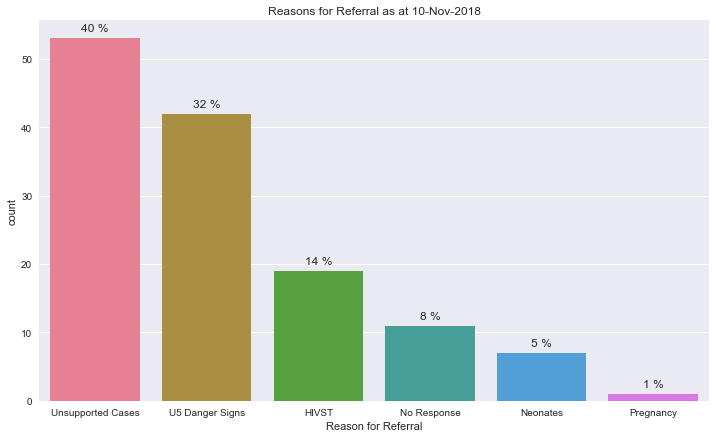

In [8]:
## Count of reasons for referral based on the broad categories
plotObject()
ax = sns.countplot( data=db, x="Reason for Referral", order=db["Reason for Referral"].value_counts().index )

# set % 
total = len( db["Reason for Referral"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.0f} %'.format(height/total*100),
            ha="center") 
    
plt.title('Reasons for Referral as at %s'% LAST_UPDATED ) ;

## Timing of Referrals

Looking at when the referrals happen and if any preferrences for different reasons for referrals

- Digital referral went live on 22-Aug. 
- HIVST referral went live on 24-Oct


    
1. The number of referrals recorded seems to be increasing over time
    - There are more referrals in subsequent months. However, this is only 2.5 months of data so far. Let's see how that holds up 
        - Do we have more referral activity now or is this just the pilot picking up? Another analysis suggests that about 84% of the main program CHVs have a referral activity the period Nov-2017 to Mar-2018. The trial CHVs has 90% of the CHVs with referral activity   


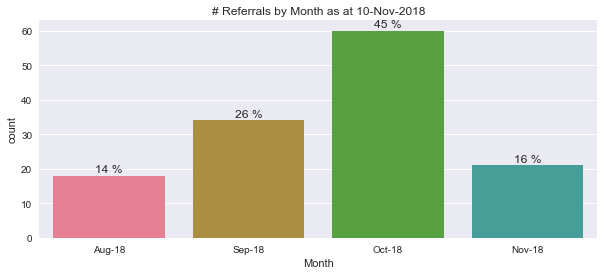

In [9]:
## 1.a. referrals by Month
plotObject(10,4)
ax = sns.countplot( data=db, x="Month" ) 
# set % 
total = len( db)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.0f} %'.format(height/total*100),
            ha="center") 
    
plt.title('# Referrals by Month as at %s'% LAST_UPDATED ) ;

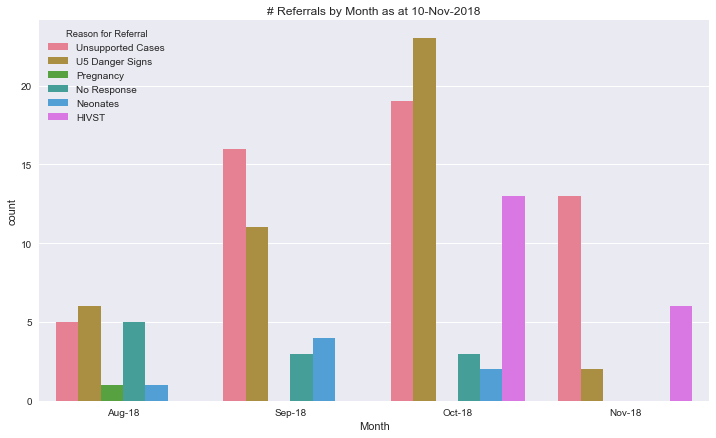

In [10]:
## 1.b referrals by Month and by reason 
plotObject()
ax = sns.countplot( data=db, x="Month" , hue="Reason for Referral",)  

plt.title('# Referrals by Month as at %s'% LAST_UPDATED) ;

2. Most of the referrals were on Mondays and Thursdays. What could this say about CHV prioritization? 
    - ICCM cases have more referrals on Mondays and Fridays
    - Neonate cases have more referrals on Mondays and all 6 cases happen in the Mon - Wed moment. 
    

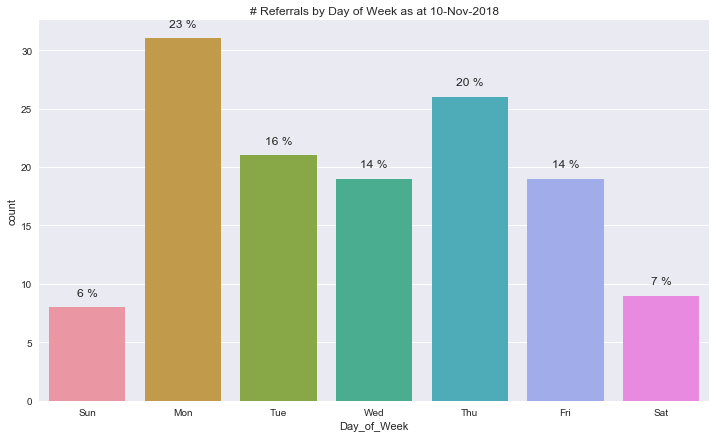

In [11]:
#display(HTML('<h5> # Referrals by Day of Week as at %s </h5>'% LAST_UPDATED) )
## 2. Referrals by Day of the Week
plotObject()
ax = sns.countplot( data=db, x="Day_of_Week", order=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"] )
# set % 
total = len( db)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.0f} %'.format(height/total*100),
            ha="center") 
    
plt.title('# Referrals by Day of Week as at %s'% LAST_UPDATED ) ;

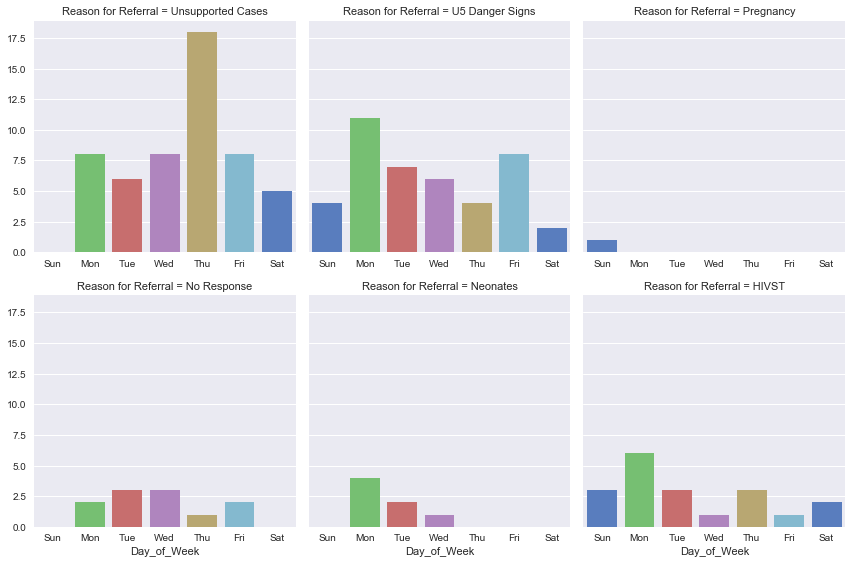

In [12]:
## 3. Referrals by Day of Week and Reason for Referral 
#plotObject( nc=3)

display(HTML('<h5> # Referrals by Day of Week and by Referral Reason as at %s </h5>'% LAST_UPDATED) )

g = sns.FacetGrid(data=db, col="Reason for Referral", size=4, aspect = 1, col_wrap=3, sharex=False).map( 
    sns.countplot, "Day_of_Week",  palette='muted', 
    order=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"] ); #.add_legend() 


## Word Clouds - Exploring the Text

Translation for Swahili to English not done. Number of swahili entries are few, though. 

Classification of cases as per above approach seems appropriate. 

- U5 related cases are most pronounced. E.G. diarrhoea, fever, cough 
- Words like 'month, two, old, health facility' relate to description of neonates and the requirement that they should be referral 
- Phrases with the word 'week' refer to duration of a symptom 




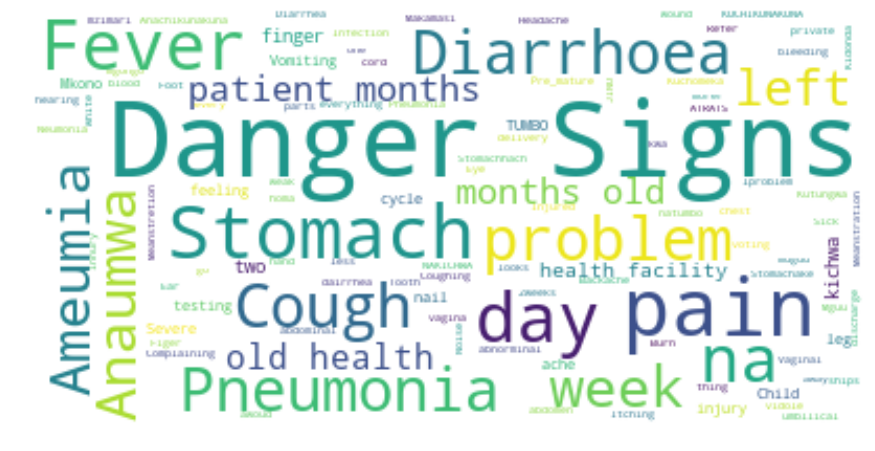

In [13]:
## stop words - use built in set of words 
stop_words = STOPWORDS.union( ["CHV", "referral" ] )
## Translating Swahili to Eng 

display(HTML('<h5>Word Cloud - All Digital Referral Reasons</h5>'))
plotObject( 15, 10)
plt.imshow( WordCloud( background_color="white", max_font_size=50, max_words=200, stopwords=stop_words,
                     ).generate( " ".join( db[db["Reason for Referral"] != var_HIVST]["Referral Reason"].fillna(' ') ) ) , interpolation='bilinear'  )
plt.axis( "off" )
plt.show(); 

**Unsupported Cases:** 

- We have 1 testing data in the live instance.
- Body Parts: head, leg, stomach, finger, tooth, back, vagina, ear
- Effects: Pain, Bleeding, menstruation, discharge, hearing, itching, infection, 
    - Mostly pain. 
- Accidents and Others: Injury, burn, wound, nail, 
- Unclear: vomiting, mucus, homa, 

In [14]:
display(HTML('<b>Number of test records </b>'))
len( db[ db['Referral Reason'].astype(str).str.contains('tes', na=False, case=False) ] )

2

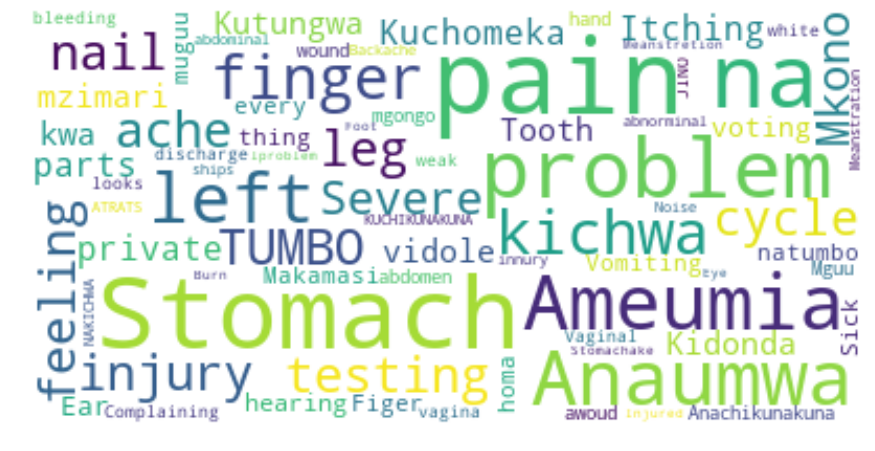

In [15]:
display(HTML('<h5>Word Cloud - Unsupported Cases only </h5>'))
plotObject( 15, 10)
plt.imshow( WordCloud( background_color="white", max_font_size=50, max_words=200,stopwords=stop_words,
                     ).generate( " ".join( db[db["Reason for Referral"] != var_HIVST][db["Reason for Referral"] ==  var_Unsupported ]["Referral Reason"].fillna(' ') ) ) , interpolation='bilinear'  )
plt.axis( "off" )
plt.show(); 

## HIVST

[Can Women Safely Distribute Oral HIVST kits? PSK, Kenya, 2017]: (http://hivst.org/evidence/can-women-safely-distribute-oral-hivst-kits-to-their-sexual-partners-results-from-a-pilot-study-in-kenya) 
	- n = 280 @ 95% FSW, 93% ANC and 86% PNC attendees
	- distributed HIVST kits to primary sexual partners 
	- IPV druing 12 months before enrollment was: 44%, 27% and 46% (FSW, ANC, PNC)
	- IPV in 3 months since study enrollment was: 21%, 13% and 16% (FSW, ANC, PNC) 
		- 85% with IPV during study had IPV at baseline 
		- only 4 attributed the IPV to distribution of the kits 
        
        
LG HIVST Study has 18% of HIVST referrals being made b/c of IPV

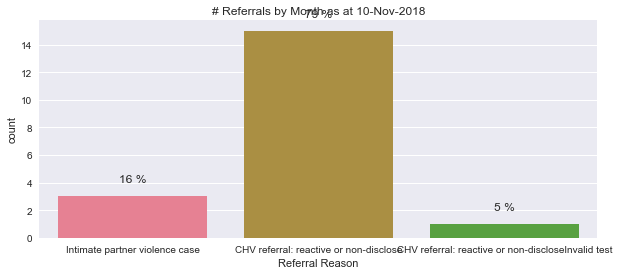

In [16]:
display(HTML('<h5> Referral Numbers - HIVST Cases only </h5>'))

plotObject(10,4)
ax = sns.countplot( data=db[ db['Reason for Referral'] == var_HIVST ], x="Referral Reason" ) 
# set % 
total = len( db[ db['Reason for Referral'] == var_HIVST ])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.0f} %'.format(height/total*100),
            ha="center") 
    
plt.title('# Referrals by Month as at %s'% LAST_UPDATED ) ;

In [17]:
## where referral reason contains 'week'
display(HTML('<h5>Referral reasons with the word <u>week</u> </h5>'))
db[ db['Referral Reason'].astype(str).str.contains('WEEK', na=False, case=False) ] [ var_Display_Colz ]

,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral
34,2018-09-27,CHV 2,Patient 34,Cough morer than one week,U5 Danger Signs
92,2018-10-01,CHV 3,Patient 64,Diarrhoea for two weeks or more,U5 Danger Signs
51,2018-10-01,CHV 3,Patient 50,Diarrhoea for two weeks or more,U5 Danger Signs
112,2018-10-01,CHV 3,Patient 50,"Diarrhoea for 2 weeks or more,",U5 Danger Signs
45,2018-10-05,CHV 7,Patient 44,Cough for 2weeks and Neumonia,U5 Danger Signs
118,2018-10-08,CHV 5,Patient 105,"Fever for 1 - 2 weeks, Danger Signs,",U5 Danger Signs


In [18]:
## Where referral reason contains 'finger or pain' 
display(HTML('<h5>Referral reasons with the word <u>finger</u> </h5>'))
db[ db['Referral Reason'].astype(str).str.contains('Finger', na=False, case=False) ][ var_Display_Colz ]


display(HTML('<h5>Referral reasons with the word <u>pain</u> </h5>'))
display(HTML('For example, <ul> <li>Rows 46, 68 and 19 could relate to pregnancy or general cases but we cannot tell from the data</li> </ul>'))
db[ db['Referral Reason'].astype(str).str.contains('pain', na=False, case=False) ][ var_Display_Colz ] 

,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral
17,2018-09-17,CHV 11,Patient 17,Finger nail ache,Unsupported Cases
24,2018-09-27,CHV 3,Patient 24,She is feeling pain on is left finger,Unsupported Cases
97,2018-09-27,CHV 3,Patient 24,She is feeling pain on is left finger,Unsupported Cases


,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral
79,2018-09-06,CHV 9,Patient 75,Stomach pain,Unsupported Cases
24,2018-09-27,CHV 3,Patient 24,She is feeling pain on is left finger,Unsupported Cases
97,2018-09-27,CHV 3,Patient 24,She is feeling pain on is left finger,Unsupported Cases
33,2018-10-16,CHV 9,Patient 33,Coughing with chest pain,U5 Danger Signs
76,2018-10-24,CHV 8,Patient 72,Severe abdominal pains,Unsupported Cases
69,2018-10-26,CHV 21,Patient 65,Severe abnorminal pain,Unsupported Cases
108,2018-11-01,CHV 22,Patient 98,Foot pain,Unsupported Cases
111,2018-11-08,CHV 9,Patient 13,Stomach pain,Unsupported Cases
13,2018-11-08,CHV 9,Patient 13,Stomach pain,Unsupported Cases
65,2018-11-08,CHV 9,Patient 13,Stomach pain,Unsupported Cases


In [19]:

## Where referral reason cotains 'stomach'
display(HTML('<h5>Referral reasons with the word <u>stomach</u> </h5>'))
db[ db['Referral Reason'].astype(str).str.contains('Stoma', na=False, case=False) ] [ var_Display_Colz ]

,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral
40,2018-08-23,CHV 3,Patient 40,Stomachhach $ dairrhea,U5 Danger Signs
52,2018-09-06,CHV 17,Patient 51,Stomach and voting,Unsupported Cases
79,2018-09-06,CHV 9,Patient 75,Stomach pain,Unsupported Cases
9,2018-10-02,CHV 8,Patient 10,Complaining of stomach problem and looks weak,Unsupported Cases
80,2018-11-01,CHV 3,Patient 76,Stomach problem,Unsupported Cases
113,2018-11-06,CHV 20,Patient 101,Stomachake,Unsupported Cases
61,2018-11-07,CHV 20,Patient 59,Stomach lproblem,Unsupported Cases
111,2018-11-08,CHV 9,Patient 13,Stomach pain,Unsupported Cases
13,2018-11-08,CHV 9,Patient 13,Stomach pain,Unsupported Cases
65,2018-11-08,CHV 9,Patient 13,Stomach pain,Unsupported Cases


In [20]:
##  All Unsupported Cases
display(HTML('<h5>All Unsupported Cases </h5>'))
db[ db['Reason for Referral'] == var_Unsupported ] [ var_Display_Colz ]

,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral
0,2018-08-09,CHV 1,Patient 1,testing testing,Unsupported Cases
14,2018-08-20,CHV 10,Patient 14,Kuchomeka,Unsupported Cases
50,2018-08-23,CHV 11,Patient 49,Itching at his private parts,Unsupported Cases
78,2018-08-28,CHV 2,Patient 74,Kutungwa mzimari,Unsupported Cases
59,2018-08-30,CHV 4,Patient 57,Kidonda kwa vidole,Unsupported Cases
87,2018-09-01,CHV 19,Patient 82,Tooth ache,Unsupported Cases
52,2018-09-06,CHV 17,Patient 51,Stomach and voting,Unsupported Cases
95,2018-09-06,CHV 9,Patient 87,Ear not hearing,Unsupported Cases
79,2018-09-06,CHV 9,Patient 75,Stomach pain,Unsupported Cases
130,2018-09-07,CHV 4,Patient 116,Vomiting every thing,Unsupported Cases


In [21]:
##  All Unsupported Cases
display(HTML('<h5>All HIVST Cases </h5>'))
db[ db['Reason for Referral'] == var_HIVST ] [ var_Display_Colz ]

,Date of referral,CHV Name,Patient Name,Referral Reason,Reason for Referral
75,2018-10-25,CHV 23,Patient 71,Intimate partner violence case,HIVST
103,2018-10-25,CHV 13,Patient 94,CHV referral: reactive or non-disclose,HIVST
30,2018-10-26,CHV 15,Patient 30,CHV referral: reactive or non-disclose,HIVST
46,2018-10-28,CHV 16,Patient 45,CHV referral: reactive or non-disclose,HIVST
96,2018-10-28,CHV 16,Patient 88,CHV referral: reactive or non-disclose,HIVST
19,2018-10-28,CHV 13,Patient 19,CHV referral: reactive or non-disclose,HIVST
73,2018-10-29,CHV 13,Patient 69,CHV referral: reactive or non-disclose,HIVST
71,2018-10-29,CHV 15,Patient 67,CHV referral: reactive or non-disclose,HIVST
58,2018-10-29,CHV 13,Patient 56,CHV referral: reactive or non-disclose,HIVST
120,2018-10-29,CHV 13,Patient 107,CHV referral: reactive or non-disclose,HIVST
